In [1]:
import gmsh
import numpy as np

el metodo initialize 'abre' el programa.

In [2]:
gmsh.initialize()

Info    : Increasing process stack size (8192 kB < 16 MB)


'armamos' el modelo que queremos modificar:

In [3]:
gmsh.model.add('test2')

In [4]:
L = 10
lc = L

Definimos las coordenadas de los puntos

In [5]:
p1 = gmsh.model.geo.addPoint(0, 0, 0, lc) #/5)
p2 = gmsh.model.geo.addPoint(L, 0, 0, lc) #*2) 
p3 = gmsh.model.geo.addPoint(L, L, 0, lc) #/2) 
p4 = gmsh.model.geo.addPoint(0, L, 0, lc) #/5) 

Luego definimos las lineas

In [6]:
l1 = gmsh.model.geo.addLine(p1, p2)
l2 = gmsh.model.geo.addLine(p2, p3)
l3 = gmsh.model.geo.addLine(p3, p4)
l4 = gmsh.model.geo.addLine(p4, p1)

Las curvas nos van a servir para definir los bordes de nuestro modelo.

In [7]:
C1 = gmsh.model.geo.addCurveLoop([l1, l2, l3, l4])

Y las superficies:

In [8]:
S1 = gmsh.model.geo.addPlaneSurface([C1])

le avisamos que ya estan todos los elementos geométricos:

In [9]:
gmsh.model.geo.synchronize()

Ahora definimos algo que nos va a servir para las condiciones de contorno.

Y definimos `Grupos Físicos` para definir bordes, etc

In [10]:
Empotrado = gmsh.model.addPhysicalGroup(1, [l4])
gmsh.model.setPhysicalName(1,Empotrado,'Empotrado')

In [11]:
Traccionado = gmsh.model.addPhysicalGroup(1, [l2])
gmsh.model.setPhysicalName(1,Traccionado,'Traccionado')

In [12]:
Superficie = gmsh.model.addPhysicalGroup(2,[S1])
gmsh.model.setPhysicalName(2,Superficie, 'Superficie')

Finalemente generamos el mallado

In [13]:
gmsh.model.mesh.generate(2)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000193733s, CPU 0.000275s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.000351094s, CPU 0.000248s)
Info    : 5 nodes 12 elements


# El objeto mesh

El mallado es un objeto del cual podemos recuperar la información necesaria para interactuar con nuestro motor de elementos finitos. Por ejemplo para la informacion de los nodos:

In [14]:
NodeInfo = gmsh.model.mesh.get_nodes()

In [15]:
NodeInfo[1].shape

(15,)

In [16]:
NodeInfo

(array([1, 2, 3, 4, 5], dtype=uint64),
 array([ 0.,  0.,  0., 10.,  0.,  0., 10., 10.,  0.,  0., 10.,  0.,  5.,
         5.,  0.]),
 array([], dtype=float64))

esta variable node info guarda:
- los numeros de nodo
- la matriz de nodo

In [17]:
NumeroNodos = NodeInfo[0].shape[0]

In [18]:
NumeroNodos

5

es la cantidad de nodos del modelo.

La matriz de nodos es dada en lista, nos conviene pasarla a matriz para tener lo que venimos trabajando:

In [19]:
MN = NodeInfo[1].reshape(NumeroNodos , 3)

In [20]:
MN

array([[ 0.,  0.,  0.],
       [10.,  0.,  0.],
       [10., 10.,  0.],
       [ 0., 10.,  0.],
       [ 5.,  5.,  0.]])

## Elementos

In [21]:
ElementInfo = gmsh.model.mesh.get_elements()

Este Objeto tiene mucha información:

In [22]:
ElementInfo

(array([ 1,  2, 15], dtype=int32),
 [array([11,  1, 12,  2], dtype=uint64),
  array([3, 4, 5, 6], dtype=uint64),
  array([ 7,  8,  9, 10], dtype=uint64)],
 [array([1, 2, 2, 3, 3, 4, 4, 1], dtype=uint64),
  array([1, 2, 5, 4, 1, 5, 2, 3, 5, 3, 4, 5], dtype=uint64),
  array([1, 2, 3, 4], dtype=uint64)])

- los tipos de elementos

In [23]:
ElementInfo[0]

array([ 1,  2, 15], dtype=int32)

Las etiquetas de los triángulos

In [24]:
ElementInfo[1][1]

array([3, 4, 5, 6], dtype=uint64)

In [25]:
ElementInfo[2][1].shape

(12,)

In [26]:
ETYPES = ElementInfo[0]

Podemos ser un poco más precabios y tomar solo los triángulos, que son los que nos interesan para la guía 

In [27]:
ETAGS, ELEMENTS = gmsh.model.mesh.get_elements_by_type(2)

In [28]:
ETAGS

array([3, 4, 5, 6], dtype=uint64)

In [29]:
ELEMENTS

array([1, 2, 5, 4, 1, 5, 2, 3, 5, 3, 4, 5], dtype=uint64)

la matriz de conectividad también hay que reformatear para tener lo que estamos acostumbrados.

In [30]:
MC = ELEMENTS.reshape([ETAGS.shape[0],3])

In [31]:
MC

array([[1, 2, 5],
       [4, 1, 5],
       [2, 3, 5],
       [3, 4, 5]], dtype=uint64)

# Condiciones de contorno

Con las definiciones de los Physical Groups, podemos sacar los índices de los nodos que estan empotrados o traccionados. Necesitamos definir una 'entidad' para los elements Traccionados:

In [32]:
entityTraccionada = gmsh.model.getEntitiesForPhysicalGroup(1, Traccionado)

In [33]:
print(entityTraccionada[0])

2


con esa entidad, podemos definir los elementos tipo línea:

In [34]:
Tgroup, Ttraccionada, Ltraccionada = gmsh.model.mesh.getElements(1, entityTraccionada[0])

In [35]:
Ttraccionada

[array([1], dtype=uint64)]

In [36]:
Ltraccionada = Ltraccionada[0].reshape(Ttraccionada[0].shape[0],2)

In [37]:
Ltraccionada 

array([[2, 3]], dtype=uint64)

Con los elementos líneas traccionadas podemos calcular las longitudes y distribuir la fuerza externa. 

In [38]:
Longitudes = np.abs( MN[Ltraccionada[:,0]-1,1] - MN[Ltraccionada[:,1]-1,1] )

Ahora puedo calcular las fuerzas:

In [39]:
Fuerzas = np.zeros((2*NumeroNodos,1))
espesor = 1
tension = 1000 #Pa

for l, linea in enumerate(Ltraccionada):
    Flocal = np.array([[1],[1]])*tension*espesor*Longitudes[l]
    n1 = linea[0]
    n2 = linea[1]
    #print(Flocal)
    Fuerzas[ np.array([2*(n1-1), 2*(n2-1)], dtype=int)] += Flocal
    

# Empotrados

Para definir los nodos empotrados necesito solamente los índices de los nodos en dicho physical group

In [40]:
NodosEmpotrados = gmsh.model.mesh.get_nodes_for_physical_group(1,Empotrado)

In [41]:
NodosEmpotrados[0]

array([1, 4], dtype=uint64)

Con eso ya puedo calcular los valores de los índices de los nodos que resultarán empotrados.

In [42]:
s = []
r = np.arange(2*NumeroNodos)
for n, nodo in enumerate(NodosEmpotrados[0]):
    s.append(
        np.linspace(2*nodo, 2*nodo +1, 2)
    )
s = np.array(s).astype(int)

luego saco de r todo lo que puse en s:

In [43]:
r = np.delete( r, s )

In [44]:
Fuerzas[r]

array([[    0.],
       [    0.],
       [10000.],
       [    0.],
       [    0.],
       [    0.]])

# Nos divertimos un rato

In [45]:
import matplotlib.pyplot as plt
from matplotlib import quiver

In [46]:
plt.style.use('default')
plt.rc('figure',figsize=(15,10))

In [47]:
Fx = Fuerzas[2*np.arange(NumeroNodos)]
Fy = Fuerzas[2*np.arange(NumeroNodos)+1]

(-1.0, 20.0)

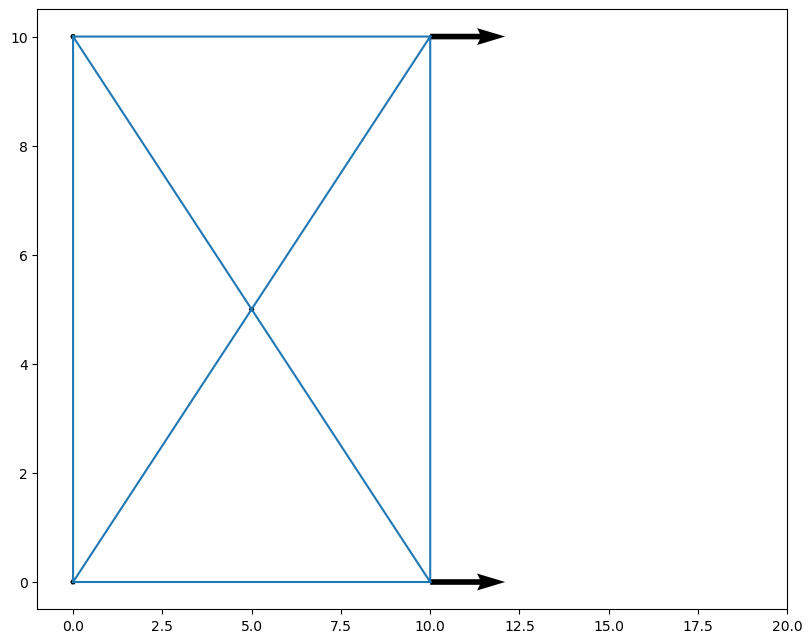

In [48]:
#plt.plot(MN[:,0],MN[:,1],'ok')

#plt.plot(MNE[:,0], MNE[:,1], label='Empotrados', lw = 5)
#plt.plot(MNT[:,0], MNT[:,1], label='Traccionados', lw = 5)
fig = plt.figure()
ax = fig.add_axes([0.1, 0.2, 0.5, 0.6])
ax.triplot(MN[:,0],MN[:,1],MC-MC.min(), )
#ax.plot(MN[:,0],MN[:,1],'o')
ax.quiver( MN[:,0], MN[:,1], Fx, Fy, linewidth=5, units='width', scale=1e5)
ax.set_xlim(-1, L+(Fx/1e3).max())

# Agregar Resulatados

Inventemos por ahora un resultado vectorial

In [49]:
DESP = np.hstack((MN[:,0].reshape(-1,1)*0.1, MN[:,1].reshape(-1,1)*0, MN[:,2].reshape(-1,1)*0))

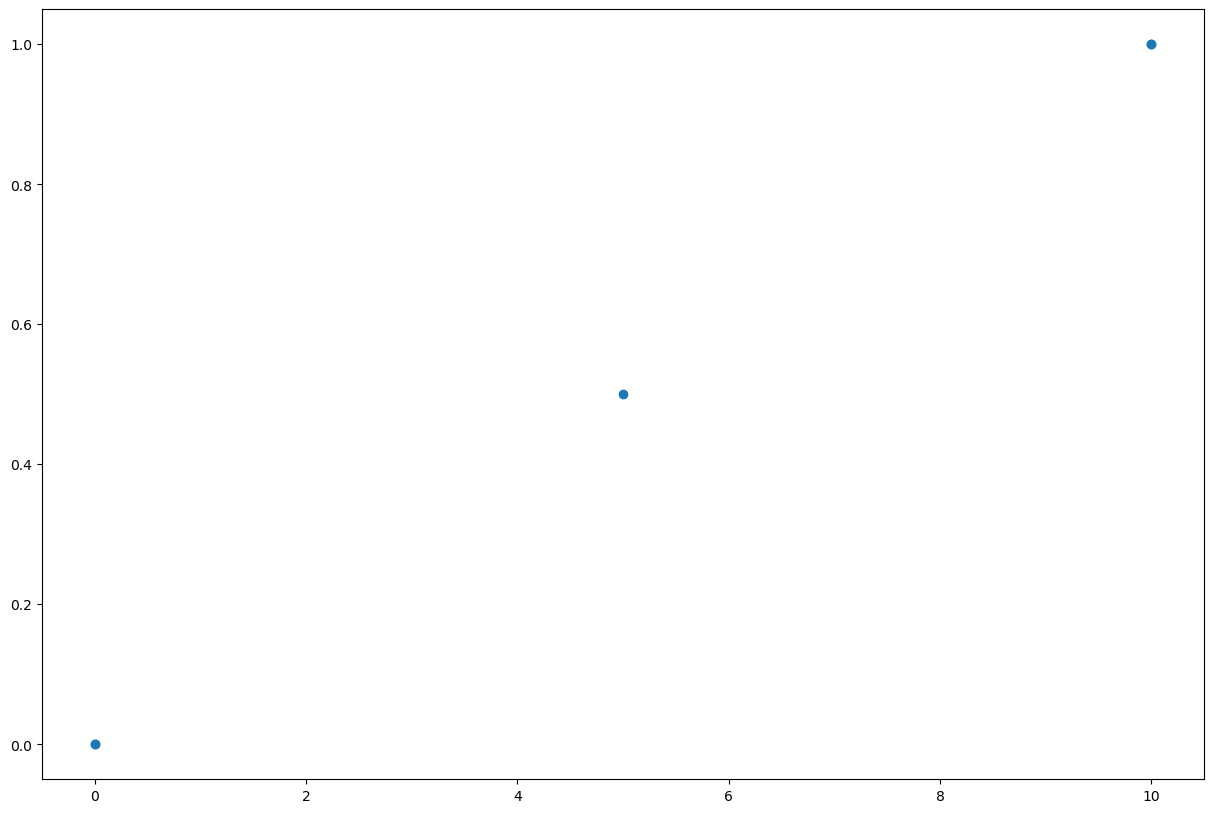

In [50]:
plt.plot(MN[:,0], DESP[:,0],'o')

Devemos iniciar una visualizacion:

In [51]:
desps = gmsh.view.add("desp")

devemos guardar esos datos en la visualizacion:

In [52]:
Desps = gmsh.view.addModelData(desps, 0, 'test2', 'NodeData', NodeInfo[0], DESP, numComponents=3)

Guardo las fuerzas externas

In [53]:
Fxyz = np.hstack((Fuerzas.reshape(NumeroNodos,2), np.zeros((NumeroNodos,1))))

In [54]:
fx = gmsh.view.add('fuerzas')
Fz = gmsh.view.addModelData(fx, 0, 'test2','NodeData',NodeInfo[0], Fxyz, numComponents=3)

Ahora le agrego un view para tensiones

In [55]:
v_t = gmsh.view.add("tens")

In [56]:
T = MC.mean(axis=1).reshape(-1,1)

In [57]:
Tensiones = gmsh.view.addModelData(v_t, 0, 'test2', 'ElementData', ETAGS, T , numComponents=1 )

vamos a jugar tambien con estos datos escalares, dependientes del tiempo:

In [58]:
Temps = gmsh.view.add("Temperaturas")

In [59]:
for i in range(100):
    gmsh.view.addModelData(Temps,i, 'test2','NodeData',NodeInfo[0],MN[:,0].reshape(-1,1)*i,numComponents=1)
    

Escribamos estos resultados con el mesh para ver mas tarde. Por razones de legibilidad humana, queremos escribir el mallado en versión 2 y no en version 4 (el default)

In [60]:
gmsh.option.setNumber("Mesh.MshFileVersion", 2.2)
gmsh.write('TestMeshView_IN.msh')
gmsh.view.write(1,"TestMeshView_OUT.msh",append=True)

Info    : Writing 'TestMeshView_IN.msh'...
Info    : Done writing 'TestMeshView_IN.msh'
Info    : Writing 'TestMeshView_OUT.msh'...
Info    : Done writing 'TestMeshView_OUT.msh'


visualicemos el resultado:

In [61]:
gmsh.fltk.run()

-------------------------------------------------------
Version       : 4.8.4
License       : GNU General Public License
Build OS      : Linux64-sdk
Build date    : 20210428
Build host    : gmsh.info
Build options : 64Bit ALGLIB ANN Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen Fltk Gmm Hxt Jpeg[fltk] Kbipack Lapack[petsc] LinuxJoystick MathEx Med Mesh Metis Mmg Mpeg Netgen ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OptHom PETSc Parser Plugins Png[fltk] Post QuadTri Solver TetGen/BR Voro++ Zlib[fltk]
FLTK version  : 1.4.0
PETSc version : 3.14.4 (real arithmtic)
OCC version   : 7.6.0
MED version   : 4.1.0
Packaged by   : geuzaine
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


In [62]:
gmsh.finalize()